In [1]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
import keras

from settings import *

from utils.general import clean_session, plot_model, split_dataset, scale_dataset, shape_dataset, print_dataset_info
from utils.models.ocr import save_model

2024-04-03 18:37:24.350678: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-03 18:37:24.727953: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 18:37:24.728095: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 18:37:24.773970: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-03 18:37:24.905332: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import Datasets.OCR.CNN_Letters.loader as CNN_Letters
import Datasets.OCR.manual.loader as manual
import Datasets.OCR.EnglishFnt.loader as EnglishFnt

In [3]:
# clean_session()

In [4]:
def create_model():
    model = Sequential()

    # CNN
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=INPUT_SHAPE))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))

    # Pooling
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))

    # Drop some data points randomly (mainly for caligraphy reasons)
    model.add(Dropout(0.25))

    # Flattening before feeding to FCNN
    model.add(Flatten())

    # FCNN
    # use softmax since we are doing classification (1 node for each possible output)
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    # model.add(Dropout(0.3))
    model.add(Dense(len(COMBINED_CHARS), activation='softmax'))

    model.summary()

    return model

In [5]:
def train_model(model, learning_rate, batch_size, epochs, patience):
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=1)]

    CX_data, CY_data = CNN_Letters.load_dataset()
    EX_data, EY_data = EnglishFnt.load_dataset(include_fonts=ENGLISH_FNT_FONTS)
    MX_data, MY_data = manual.load_dataset()
    X_data = np.concatenate((CX_data, MX_data, EX_data))
    Y_data = np.concatenate((CY_data, MY_data, EY_data))

    X_train, X_test, Y_train, Y_test = split_dataset(X_data, Y_data, test_percent=TEST_PERCENT, random_state=RANDOM_STATE, shuffle=True)
    X_train, X_test = shape_dataset(X_train, X_test, input_shape=INPUT_SHAPE)
    X_train, X_test = scale_dataset(X_train, X_test, batch_size=batch_size)

    print_dataset_info(X_data, X_train, Y_train, X_test, Y_test)

    history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_split=VALIDATION_PERCENT, callbacks=callbacks)

    return history

2024-04-03 18:37:32.100964: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-03 18:37:32.291484: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-03 18:37:32.292165: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 48, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 98, 48, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 46, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 94, 44, 128)       73856     
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 22, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 47, 22, 128)       0

Loading CNN_Letters:   0%|          | 0/35 [00:00<?, ?it/s]

Loading 0:   0%|          | 0/1030 [00:00<?, ?it/s]

Loading 1:   0%|          | 0/1030 [00:00<?, ?it/s]

Loading 2:   0%|          | 0/1030 [00:00<?, ?it/s]

Loading 3:   0%|          | 0/1030 [00:00<?, ?it/s]

Loading 4:   0%|          | 0/1030 [00:00<?, ?it/s]

Loading 5:   0%|          | 0/1030 [00:00<?, ?it/s]

Loading 6:   0%|          | 0/1030 [00:00<?, ?it/s]

Loading 7:   0%|          | 0/1030 [00:00<?, ?it/s]

Loading 8:   0%|          | 0/1030 [00:00<?, ?it/s]

Loading 9:   0%|          | 0/1030 [00:00<?, ?it/s]

Loading A:   0%|          | 0/1010 [00:00<?, ?it/s]

Loading B:   0%|          | 0/1030 [00:00<?, ?it/s]

Loading C:   0%|          | 0/1020 [00:00<?, ?it/s]

Loading D:   0%|          | 0/1010 [00:00<?, ?it/s]

Loading E:   0%|          | 0/1010 [00:00<?, ?it/s]

Loading F:   0%|          | 0/1020 [00:00<?, ?it/s]

Loading G:   0%|          | 0/1020 [00:00<?, ?it/s]

Loading H:   0%|          | 0/1020 [00:00<?, ?it/s]

Loading I:   0%|          | 0/1010 [00:00<?, ?it/s]

Loading J:   0%|          | 0/1030 [00:00<?, ?it/s]

Loading K:   0%|          | 0/1010 [00:00<?, ?it/s]

Loading L:   0%|          | 0/1010 [00:00<?, ?it/s]

Loading M:   0%|          | 0/1020 [00:00<?, ?it/s]

Loading N:   0%|          | 0/1020 [00:00<?, ?it/s]

Loading P:   0%|          | 0/1010 [00:00<?, ?it/s]

Loading Q:   0%|          | 0/1010 [00:00<?, ?it/s]

Loading R:   0%|          | 0/1020 [00:00<?, ?it/s]

Loading S:   0%|          | 0/1020 [00:00<?, ?it/s]

Loading T:   0%|          | 0/1020 [00:00<?, ?it/s]

Loading U:   0%|          | 0/1010 [00:00<?, ?it/s]

Loading V:   0%|          | 0/1030 [00:00<?, ?it/s]

Loading W:   0%|          | 0/1010 [00:00<?, ?it/s]

Loading X:   0%|          | 0/1010 [00:00<?, ?it/s]

Loading Y:   0%|          | 0/1010 [00:00<?, ?it/s]

Loading Z:   0%|          | 0/810 [00:00<?, ?it/s]

Loading EnglishFnt:   0%|          | 0/35 [00:00<?, ?it/s]

Loading 0:   0%|          | 0/698 [00:00<?, ?it/s]

Loading 1:   0%|          | 0/698 [00:00<?, ?it/s]

Loading 2:   0%|          | 0/698 [00:00<?, ?it/s]

Loading 3:   0%|          | 0/698 [00:00<?, ?it/s]

Loading 4:   0%|          | 0/698 [00:00<?, ?it/s]

Loading 5:   0%|          | 0/698 [00:00<?, ?it/s]

Loading 6:   0%|          | 0/698 [00:00<?, ?it/s]

Loading 7:   0%|          | 0/698 [00:00<?, ?it/s]

Loading 8:   0%|          | 0/698 [00:00<?, ?it/s]

Loading 9:   0%|          | 0/698 [00:00<?, ?it/s]

Loading A:   0%|          | 0/698 [00:00<?, ?it/s]

Loading B:   0%|          | 0/698 [00:00<?, ?it/s]

Loading C:   0%|          | 0/698 [00:00<?, ?it/s]

Loading D:   0%|          | 0/698 [00:00<?, ?it/s]

Loading E:   0%|          | 0/698 [00:00<?, ?it/s]

Loading F:   0%|          | 0/698 [00:00<?, ?it/s]

Loading G:   0%|          | 0/698 [00:00<?, ?it/s]

Loading H:   0%|          | 0/698 [00:00<?, ?it/s]

Loading I:   0%|          | 0/698 [00:00<?, ?it/s]

Loading J:   0%|          | 0/698 [00:00<?, ?it/s]

Loading K:   0%|          | 0/698 [00:00<?, ?it/s]

Loading L:   0%|          | 0/698 [00:00<?, ?it/s]

Loading M:   0%|          | 0/698 [00:00<?, ?it/s]

Loading N:   0%|          | 0/698 [00:00<?, ?it/s]

Loading P:   0%|          | 0/698 [00:00<?, ?it/s]

Loading Q:   0%|          | 0/698 [00:00<?, ?it/s]

Loading R:   0%|          | 0/698 [00:00<?, ?it/s]

Loading S:   0%|          | 0/698 [00:00<?, ?it/s]

Loading T:   0%|          | 0/698 [00:00<?, ?it/s]

Loading U:   0%|          | 0/698 [00:00<?, ?it/s]

Loading V:   0%|          | 0/698 [00:00<?, ?it/s]

Loading W:   0%|          | 0/698 [00:00<?, ?it/s]

Loading X:   0%|          | 0/698 [00:00<?, ?it/s]

Loading Y:   0%|          | 0/698 [00:00<?, ?it/s]

Loading Z:   0%|          | 0/698 [00:00<?, ?it/s]

Loading manual:   0%|          | 0/35 [00:00<?, ?it/s]

Loading 0:   0%|          | 0/30 [00:00<?, ?it/s]

Loading 1:   0%|          | 0/30 [00:00<?, ?it/s]

Loading 2:   0%|          | 0/30 [00:00<?, ?it/s]

Loading 3:   0%|          | 0/30 [00:00<?, ?it/s]

Loading 4:   0%|          | 0/30 [00:00<?, ?it/s]

Loading 5:   0%|          | 0/30 [00:00<?, ?it/s]

Loading 6:   0%|          | 0/30 [00:00<?, ?it/s]

Loading 7:   0%|          | 0/30 [00:00<?, ?it/s]

Loading 8:   0%|          | 0/30 [00:00<?, ?it/s]

Loading 9:   0%|          | 0/30 [00:00<?, ?it/s]

Loading A:   0%|          | 0/30 [00:00<?, ?it/s]

Loading B:   0%|          | 0/30 [00:00<?, ?it/s]

Loading C:   0%|          | 0/30 [00:00<?, ?it/s]

Loading D:   0%|          | 0/30 [00:00<?, ?it/s]

Loading E:   0%|          | 0/30 [00:00<?, ?it/s]

Loading F:   0%|          | 0/30 [00:00<?, ?it/s]

Loading G:   0%|          | 0/30 [00:00<?, ?it/s]

Loading H:   0%|          | 0/30 [00:00<?, ?it/s]

Loading I:   0%|          | 0/30 [00:00<?, ?it/s]

Loading J:   0%|          | 0/30 [00:00<?, ?it/s]

Loading K:   0%|          | 0/30 [00:00<?, ?it/s]

Loading L:   0%|          | 0/30 [00:00<?, ?it/s]

Loading M:   0%|          | 0/30 [00:00<?, ?it/s]

Loading N:   0%|          | 0/30 [00:00<?, ?it/s]

Loading P:   0%|          | 0/30 [00:00<?, ?it/s]

Loading Q:   0%|          | 0/30 [00:00<?, ?it/s]

Loading R:   0%|          | 0/30 [00:00<?, ?it/s]

Loading S:   0%|          | 0/30 [00:00<?, ?it/s]

Loading T:   0%|          | 0/30 [00:00<?, ?it/s]

Loading U:   0%|          | 0/30 [00:00<?, ?it/s]

Loading V:   0%|          | 0/30 [00:00<?, ?it/s]

Loading W:   0%|          | 0/30 [00:00<?, ?it/s]

Loading X:   0%|          | 0/30 [00:00<?, ?it/s]

Loading Y:   0%|          | 0/30 [00:00<?, ?it/s]

Loading Z:   0%|          | 0/30 [00:00<?, ?it/s]

Data samples: 180840
X_train shape: 162756
Y_train shape: 162756
X_test shape: 18084
Y_test shape: 18084
Epoch 1/25


2024-04-03 18:38:31.865441: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-03 18:38:33.471032: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-04-03 18:38:33.750529: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-03 18:38:35.083618: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-03 18:38:36.025689: I external/local_xla/xla/service/service.cc:168] XLA service 0x76c4511ad5c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-03 18:38:36.025729: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 30

2034/2035 [============================>.] - ETA: 0s - loss: 1.2013 - accuracy: 0.6714

2024-04-03 18:40:56.189991: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-03 18:40:56.363502: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


2035/2035 [==============================] - 159s 71ms/step - loss: 1.2010 - accuracy: 0.6715 - val_loss: 0.1691 - val_accuracy: 0.9523
Epoch 2/25
2035/2035 [==============================] - 141s 69ms/step - loss: 0.1277 - accuracy: 0.9620 - val_loss: 0.0892 - val_accuracy: 0.9744
Epoch 3/25
2035/2035 [==============================] - 141s 69ms/step - loss: 0.0773 - accuracy: 0.9760 - val_loss: 0.0794 - val_accuracy: 0.9773
Epoch 4/25
2035/2035 [==============================] - 141s 69ms/step - loss: 0.0596 - accuracy: 0.9815 - val_loss: 0.0801 - val_accuracy: 0.9770
Epoch 5/25
2035/2035 [==============================] - 141s 69ms/step - loss: 0.0454 - accuracy: 0.9854 - val_loss: 0.0600 - val_accuracy: 0.9836
Epoch 6/25
2035/2035 [==============================] - 141s 69ms/step - loss: 0.0377 - accuracy: 0.9879 - val_loss: 0.0480 - val_accuracy: 0.9873
Epoch 7/25
2035/2035 [==============================] - 141s 69ms/step - loss: 0.0318 - accuracy: 0.9896 - val_loss: 0.0491 - val

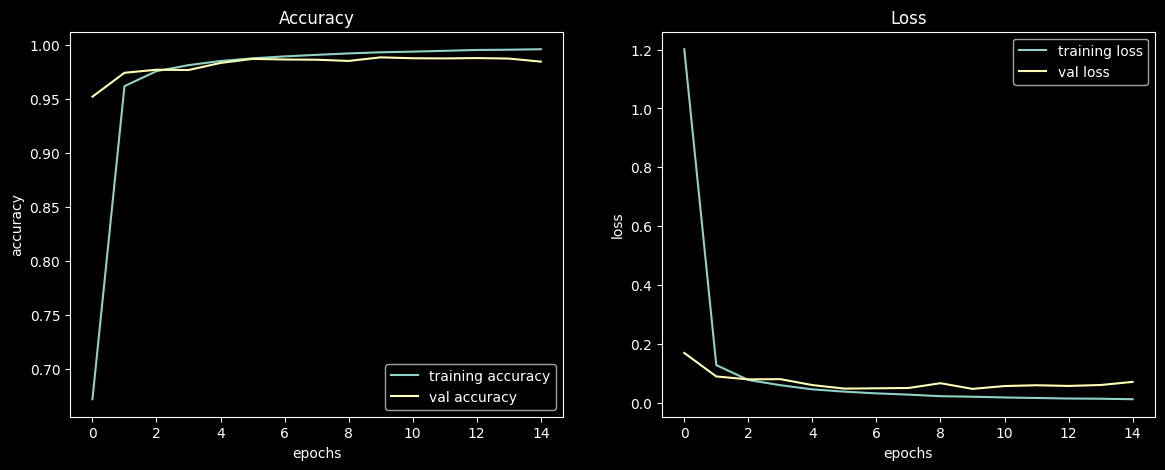

Saved model v4 to disk


: 

In [6]:
model = create_model()
history = train_model(model, learning_rate=0.001, batch_size=64, epochs=25, patience=5)
plot_model(history, 4, save=True)
save_model(model, 4)